![Airbnb logo](https://japanesquest.com/wp-content/uploads/2017/10/airbnb-logo.png)

# Post-Covid19 Survival Kit for Airbnb Hosts

## Dinis Oliveira Costa | Data Part-time Dec 2019

The goal of this project was to identify the key aspects of the airbnb market in Barcelona and analyse the key aspects throughout the different neighbourhoods around the city.
The workflow consisted of an extensive exploratory data analysis of listings in Barcelona and the construction of a machine learning model capable of predicting the most recommendable price.

In [93]:
# Data Manipulation Modules
import numpy as np                
import pandas as pd                
import scipy                       

# Seaborn and Matplotlib Visualization
import matplotlib                  
import matplotlib.pyplot as plt
import seaborn as sns              
import geopandas as gpd
plt.style.use('fivethirtyeight') 
plt.rcParams["figure.figsize"] = (20,6)
%matplotlib inline

# Plotly Visualization
import plotly as plotly                
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

# Spatial Visualizations
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Misc libraries
import random
import time
import math

# NLP - WordCloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [94]:
# Summary information and metrics for listings in Barcelona (good for visualisations)
sum_listings = pd.read_csv('/Users/Dinis/Ironhack/Projects/airbnb_final_project/data/summary_listings.csv')

## 1. Data Wrangling

In [95]:
sum_listings.shape

(20858, 16)

In [96]:
sum_listings.head()

id                                             name  host_id  \
0  21974               Comf. double room/private bathroom    73163   
1  23197  Forum DeLuxe 5 mins Walk  To CCIB Center & Sea★    90417   
2  31958                  Gaudi Attic 1, Friendly Rentals   136853   
3  32471                  Gaudi Attic 2, Friendly Rentals   136853   
4  32711                 Sagrada Familia area - Còrsega 1   135703   

        host_name neighbourhood_group                       neighbourhood  \
0          Andres        Ciutat Vella                      el Barri Gòtic   
1  Etain (Marnie)          Sant Martí               el Besòs i el Maresme   
2         Fidelio              Gràcia  el Camp d'en Grassot i Gràcia Nova   
3         Fidelio              Gràcia  el Camp d'en Grassot i Gràcia Nova   
4            Nick              Gràcia  el Camp d'en Grassot i Gràcia Nova   

   latitude  longitude        room_type  price  minimum_nights  \
0  41.38077    2.17551     Private room     60               3   
1  41.41291    2.22063  Entire home/apt    220               3   
2  41.40950    2.15938  Entire home/apt     58               1   
3  41.40928    2.16112  Entire home/apt     66               1   
4  41.40566    2.17015  Entire home/apt    140               2   

   number_of_reviews last_review  reviews_per_month  \
0                  2  2017-11-06               0.05   
1                 52  2019-12-15               0.47   
2                188  2020-03-09               1.67   
3                 94  2020-03-07               0.83   
4                 63  2020-02-22               0.59   

   calculated_host_listings_count  availability_365  
0                               3                90  
1                               2               345  
2                              29               337  
3                              29               331  
4                               6               329

In [97]:
sum_listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [98]:
sum_listings.shape

(20858, 16)

In [99]:
# change last_review to numerical? 
sum_listings.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [100]:
# Calculating missing values 

sum_listings.isnull().sum()

id                                   0
name                                15
host_id                              0
host_name                            6
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       5347
reviews_per_month                 5347
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [101]:
# Replacing missing values in reviews_per_month for 0
sum_listings['reviews_per_month'].fillna(value=0, inplace=True)

In [102]:
# Dropping the columns id, host_name and last_review
columns = ['id','host_name','last_review']

sum_listings.drop(columns, axis = 1,inplace=True) 

In [103]:
# Dropping the missing values in the column name
sum_listings = sum_listings.dropna(subset=['name'])

In [104]:
sum_listings.isnull().sum()

name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Text(0.5, 1.0, 'Availability 365')

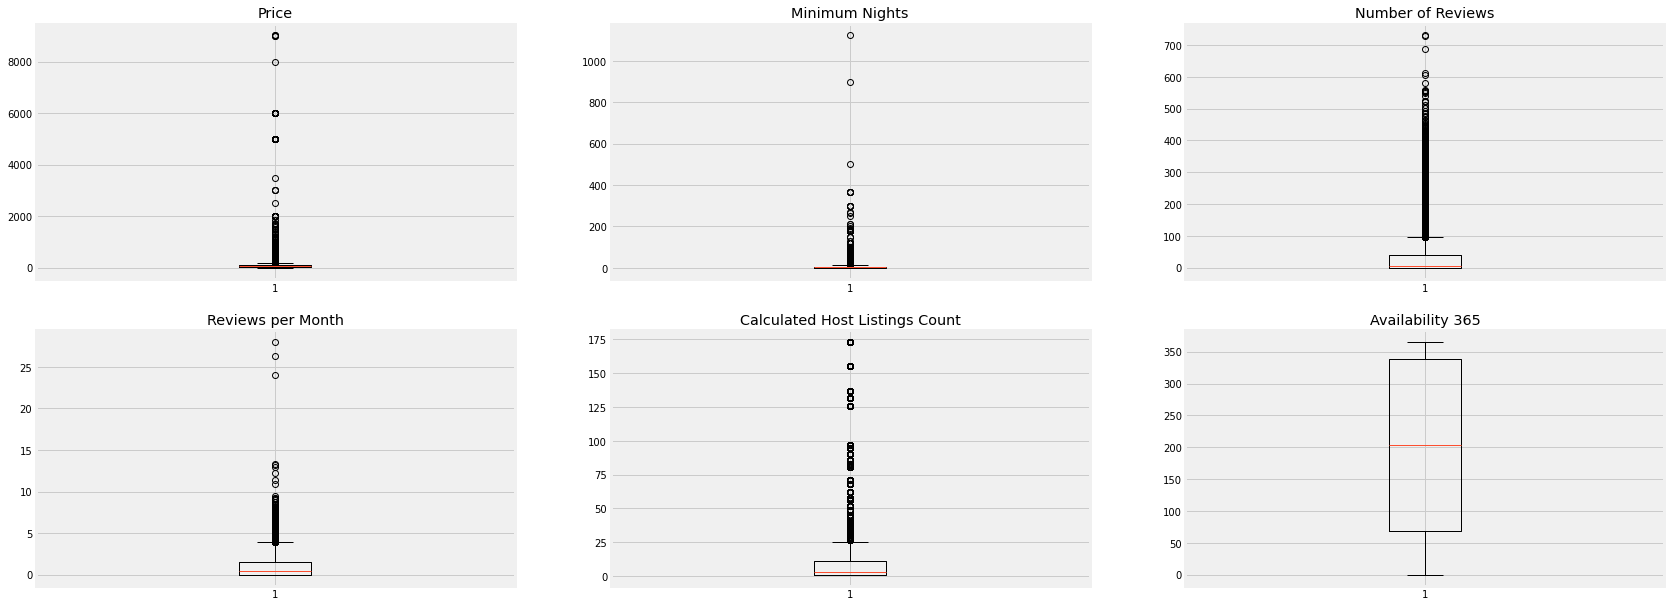

In [105]:
# Plotting boxplots for price, minimum_rights, number_of_reviews, reviews_per_month, calculated_host_listings_count, 
# availability_365

plt.figure(figsize = (26, 16))

ax=plt.subplot(331)
plt.boxplot(sum_listings['price'])
ax.set_title('Price')

ax=plt.subplot(332)
plt.boxplot(sum_listings['minimum_nights'])
ax.set_title('Minimum Nights')

ax=plt.subplot(333)
plt.boxplot(sum_listings['number_of_reviews'])
ax.set_title('Number of Reviews')

ax=plt.subplot(334)
plt.boxplot(sum_listings['reviews_per_month'])
ax.set_title('Reviews per Month')

ax=plt.subplot(335)
plt.boxplot(sum_listings['calculated_host_listings_count'])
ax.set_title('Calculated Host Listings Count')

ax=plt.subplot(336)
plt.boxplot(sum_listings['availability_365'])
ax.set_title('Availability 365')

- Most variables reveal a large number of outliers -  data points that differs significantly from the other observations - which need to be cleaned before interpretating 

In [106]:
# Interquartile range (IQR) method: 
# the interquartile range (IQR), also called the midspread, is a measure of statistical dispersion, 
# being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, 
# IQR = Q3 − Q1.

# Fixing PRICE 
Q1 = sum_listings['price'].quantile(0.25)
Q3 = sum_listings['price'].quantile(0.75)
IQR = Q3 - Q1    
print('IQR Price:', IQR)

# Commonly used rule says that a data point is an outlier if it is more than 1.5 * IQR

filtered_price = (sum_listings['price'] >= Q1 - 1.5 * IQR) & (sum_listings['price'] <= Q3 + 1.5 *IQR)
fp_sum_listings =sum_listings.loc[filtered_price]

IQR Price: 64.0


In [107]:
# Fixing NUMBER OF REVIEWS 
Q1 = fp_sum_listings['number_of_reviews'].quantile(0.25)
Q3 = fp_sum_listings['number_of_reviews'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
print('IQR Number of Reviews:', IQR)


filtered_reviews = (fp_sum_listings['number_of_reviews'] >= Q1 - 1.5 * IQR) & (fp_sum_listings['number_of_reviews'] <= Q3 + 1.5 *IQR)
fr_sum_listings =fp_sum_listings.loc[filtered_reviews]

IQR Number of Reviews: 40.0


In [108]:
# Fixing REVIEWS PER MONTH
Q1 = fr_sum_listings['reviews_per_month'].quantile(0.25)
Q3 = fr_sum_listings['reviews_per_month'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
print('IQR Reviews per month:', IQR)

filtered_reviews_per_month = (fr_sum_listings['reviews_per_month'] >= Q1 - 1.5 * IQR) & (fr_sum_listings['reviews_per_month'] <= Q3 + 1.5 *IQR)
clean_sum_listings =fr_sum_listings.loc[filtered_reviews_per_month]

IQR Reviews per month: 1.08


## 2. Data Visualization

### 2.1 Visualization categorical variables

Text(0.5, 1.0, 'Top 5 Neighbourhood Groups with largest number of listings')

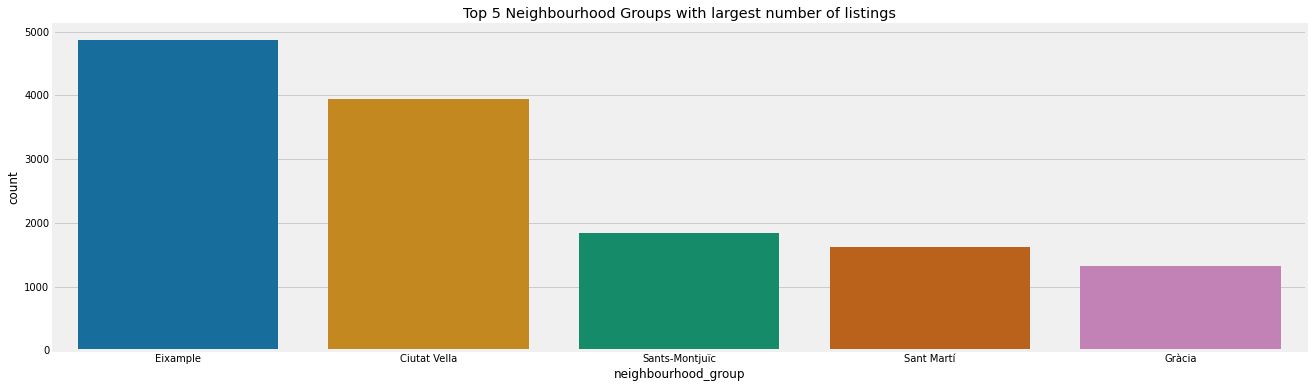

In [109]:
# Plotting the Top 5 Neighbourhood Groups with largest number of listings

plt.figure(figsize = (20, 6))

ax = sns.countplot(x='neighbourhood_group', data=clean_sum_listings, palette='colorblind', 
              order=clean_sum_listings.neighbourhood_group.value_counts().iloc[:5].index)

ax.set_title(label = 'Top 5 Neighbourhood Groups with largest number of listings')

- The majority of Airbnb listings in Barcelona are located in **Eixample**, **Ciutat Vella** and **Sants-Montjuic**

In [110]:
def weight_col(col):
    
    # calculating the weight of which each value represents towards the total

    column_values = list(col.unique())

    for i in column_values:
        listings = len(col[col== i])
        listings_weight = round(listings/len(col)*100,2)
    
        print(f'\n {i}, {listings} listings, {listings_weight}% of Barcelona')

In [111]:
# Calculating the distribution of neighbourhood groups in Barcelona

weight_col(clean_sum_listings['neighbourhood_group'])


 Ciutat Vella, 3942 listings, 25.02% of Barcelona

 Gràcia, 1329 listings, 8.44% of Barcelona

 Eixample, 4873 listings, 30.93% of Barcelona

 Sants-Montjuïc, 1839 listings, 11.67% of Barcelona

 Sant Martí, 1618 listings, 10.27% of Barcelona

 Sarrià-Sant Gervasi, 645 listings, 4.09% of Barcelona

 Horta-Guinardó, 566 listings, 3.59% of Barcelona

 Sant Andreu, 303 listings, 1.92% of Barcelona

 Les Corts, 385 listings, 2.44% of Barcelona

 Nou Barris, 253 listings, 1.61% of Barcelona


- **Eixample** and **Ciutat Vella** account for more than a third (42,26%) of the places published online
- Between these two neighbourhoods groups there are almost 9000 listings (8815)

Text(0.5, 1.0, 'Top 5 Neighbourhoods with largest number of listings')

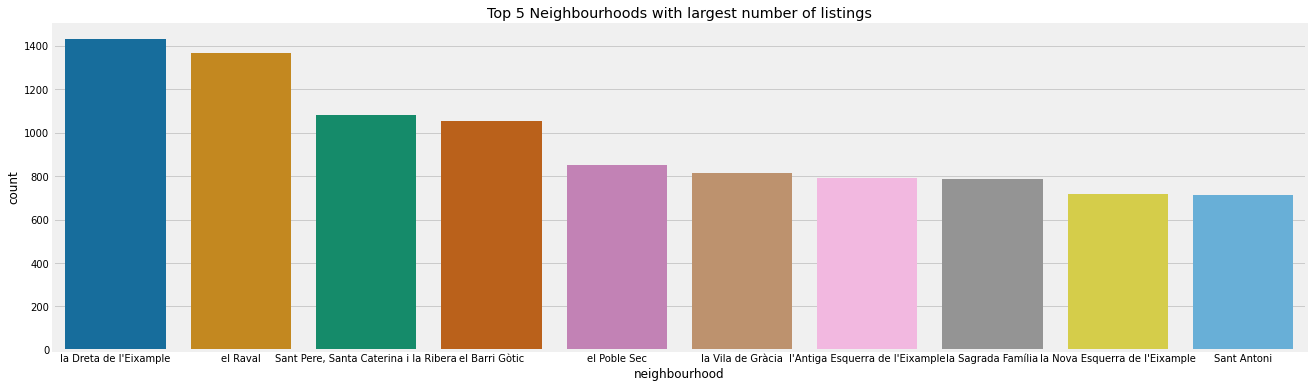

In [112]:
# Plotting the Top 10 Neighbourhoods with the most listings in Barcelona

plt.figure(figsize = (20, 6))

ax=sns.countplot(x='neighbourhood', data=clean_sum_listings, palette='colorblind', 
                 order=clean_sum_listings.neighbourhood.value_counts().iloc[:10].index)

ax.set_title(label = 'Top 5 Neighbourhoods with largest number of listings')


In [113]:
clean_sum_listings.columns

Index(['name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [114]:
weight_col(clean_sum_listings.neighbourhood)


 el Barri Gòtic, 1054 listings, 6.69% of Barcelona

 el Camp d'en Grassot i Gràcia Nova, 284 listings, 1.8% of Barcelona

 la Barceloneta, 439 listings, 2.79% of Barcelona

 Sant Pere, Santa Caterina i la Ribera, 1082 listings, 6.87% of Barcelona

 la Dreta de l'Eixample, 1431 listings, 9.08% of Barcelona

 l'Antiga Esquerra de l'Eixample, 792 listings, 5.03% of Barcelona

 el Fort Pienc, 432 listings, 2.74% of Barcelona

 el Raval, 1367 listings, 8.68% of Barcelona

 el Poble Sec, 851 listings, 5.4% of Barcelona

 la Sagrada Família, 788 listings, 5.0% of Barcelona

 el Clot, 135 listings, 0.86% of Barcelona

 Vallvidrera, el Tibidabo i les Planes, 20 listings, 0.13% of Barcelona

 Sant Antoni, 714 listings, 4.53% of Barcelona

 el Guinardó, 161 listings, 1.02% of Barcelona

 el Camp de l'Arpa del Clot, 296 listings, 1.88% of Barcelona

 Sant Andreu, 74 listings, 0.47% of Barcelona

 Sants, 313 listings, 1.99% of Barcelona

 Pedralbes, 22 listings, 0.14% of Barcelona

 Diagonal Mar i

Text(0, 0.5, '')

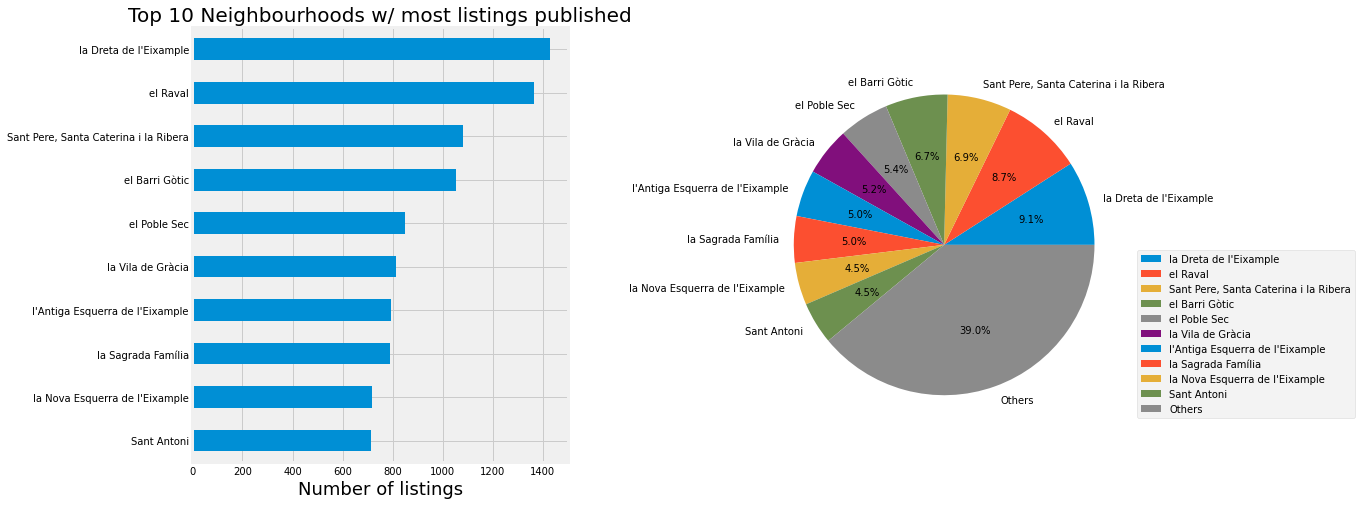

In [115]:
# Plotting barplot Top 10 Neighbourhoods w/ most listings in Barcelona 
fig,ax=plt.subplots(1,2,figsize=(15,8))
clean_sum_listings.neighbourhood.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',ax=ax[0])
ax[0].set_title('Top 10 Neighbourhoods w/ most listings published', size=20)
ax[0].set_xlabel('Number of listings',size=18)

# Selecting the top 10 neighbourhoods  
top_neigh = clean_sum_listings['neighbourhood'].value_counts()

# Counting the number of listings in each of the top 10 neighbourhoods  
counts = list(top_neigh[:10])
counts.append(top_neigh.agg(sum)-top_neigh[:10].agg('sum'))

# Grouping the neighbourhoods in a list and adding a category "Others"
groups = list(clean_sum_listings['neighbourhood'].value_counts().index)[:10]
groups.append('Others')

# Creating a DataFrame containing all the neighbourhoods and number of listings in each 
neighb_df = pd.DataFrame({'group':groups,'counts' :counts})
pie_chart = neighb_df.plot(kind='pie', y='counts', labels=groups, autopct='%1.1f%%', ax=ax[1])

# Adjusting the legend for the pie chart and the amount of width reserved for space between subplots
plt.legend(loc=0, bbox_to_anchor=(1,0.5)) 
plt.subplots_adjust(wspace =0.5, hspace =0)

# Deleting y-axis label from the pie chart
plt.ylabel('')

- The neighbourhoods of **la Dreta de l'Eixample**, **el Raval**, **Sant Pere, Santa Caterina i la Ribera** concentrate about 25% of all the Airbnb listings available in Barcelona

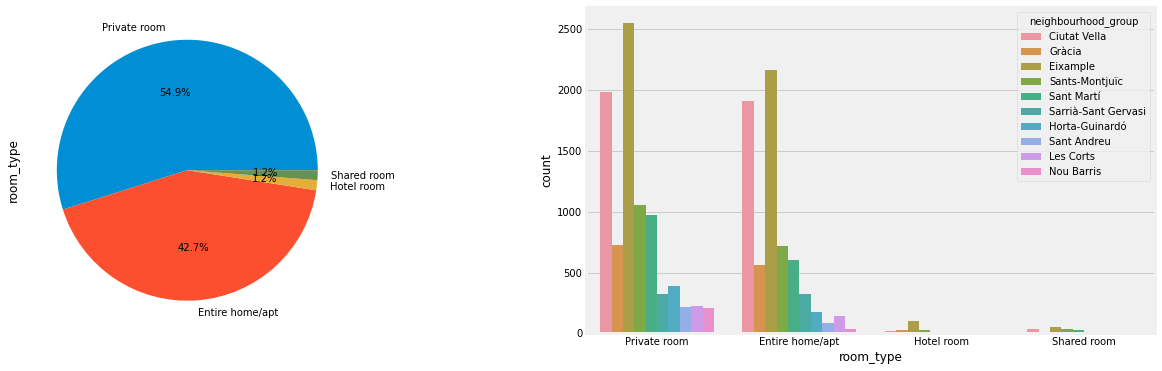

In [116]:
# Plotting room_type per neighbourhood_group

plt.figure(figsize = (20, 6))

plt.subplot(121)
ax1= clean_sum_listings['room_type'].value_counts().plot.pie(autopct='%1.1f%%')
                                                             
plt.subplot(122)
ax2= sns.countplot(x = 'room_type',hue = "neighbourhood_group",data = clean_sum_listings)

- The distribution of **room types** across Barcelona reveals a slightly larger number of private rooms 
- **Eixample** and **Sants-Montjuic** show a significantly larger number of private rooms when compared to other neighbourhoods
- **Ciutat Vella** has a very similar number of listings of both private rooms and entire homes

In [117]:
weight_col(clean_sum_listings.room_type)


 Private room, 8645 listings, 54.88% of Barcelona

 Entire home/apt, 6720 listings, 42.66% of Barcelona

 Hotel room, 196 listings, 1.24% of Barcelona

 Shared room, 192 listings, 1.22% of Barcelona


### 2.2 Numerical Variables Visualization

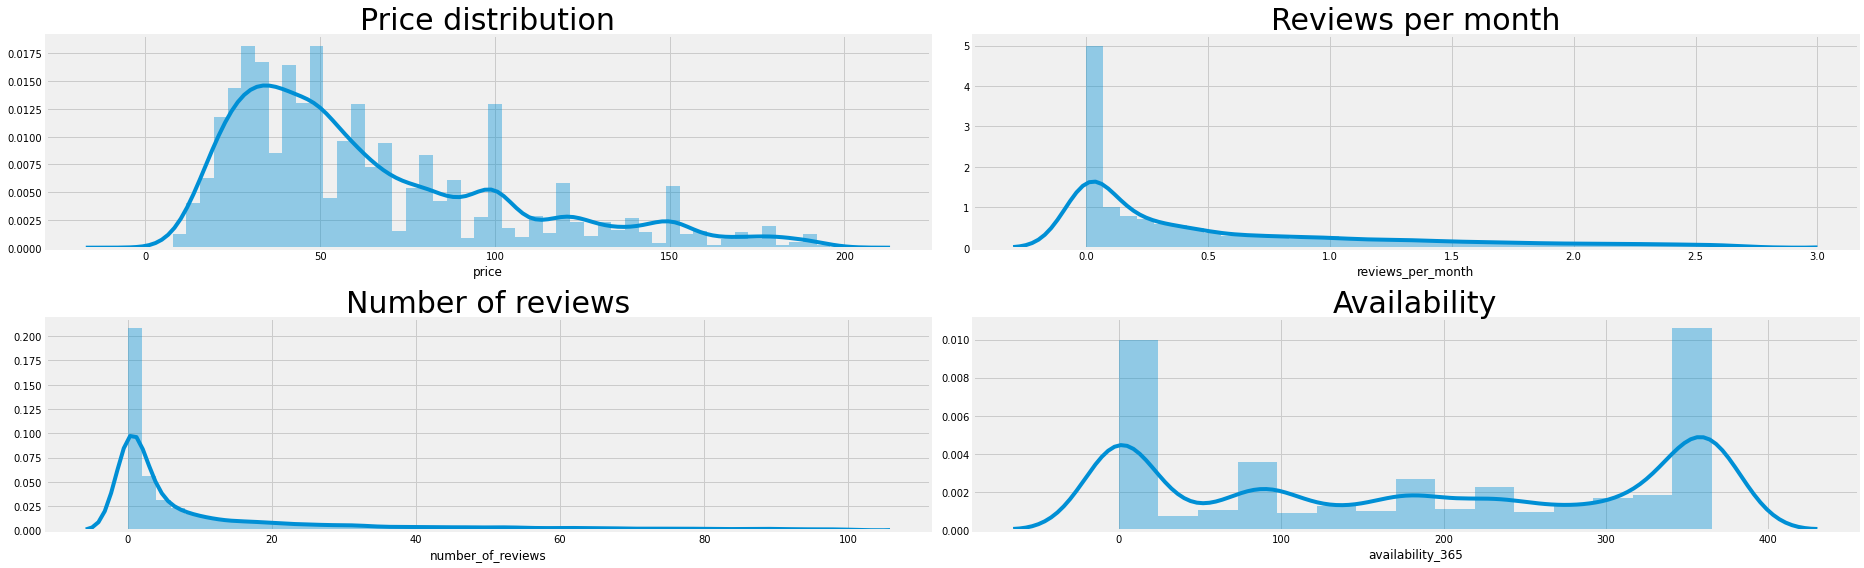

In [118]:
# Plotting price, reviews_per_month, numbers_of_reviews, availability_365

plt.figure(figsize = (26, 8))

plt.subplot(221)
ax1=sns.distplot(clean_sum_listings['price'])
ax1.set_title(label = 'Price distribution', fontsize = 30)
plt.tight_layout()

plt.subplot(222)
ax2=sns.distplot(clean_sum_listings['reviews_per_month'])
ax2.set_title(label = 'Reviews per month', fontsize = 30)
plt.tight_layout()

plt.subplot(223)
ax3=sns.distplot(clean_sum_listings['number_of_reviews'])
ax3.set_title(label = 'Number of reviews', fontsize = 30)
plt.tight_layout()

plt.subplot(224)
ax4=sns.distplot(clean_sum_listings['availability_365'])
ax4.set_title(label = 'Availability', fontsize = 30)
plt.tight_layout()

- Looking at the numerical variables, they all seem to be right skewed distributed except for availabilty
- Since there's a high number of private rooms, the distribution seems right-skewed (positive skew)

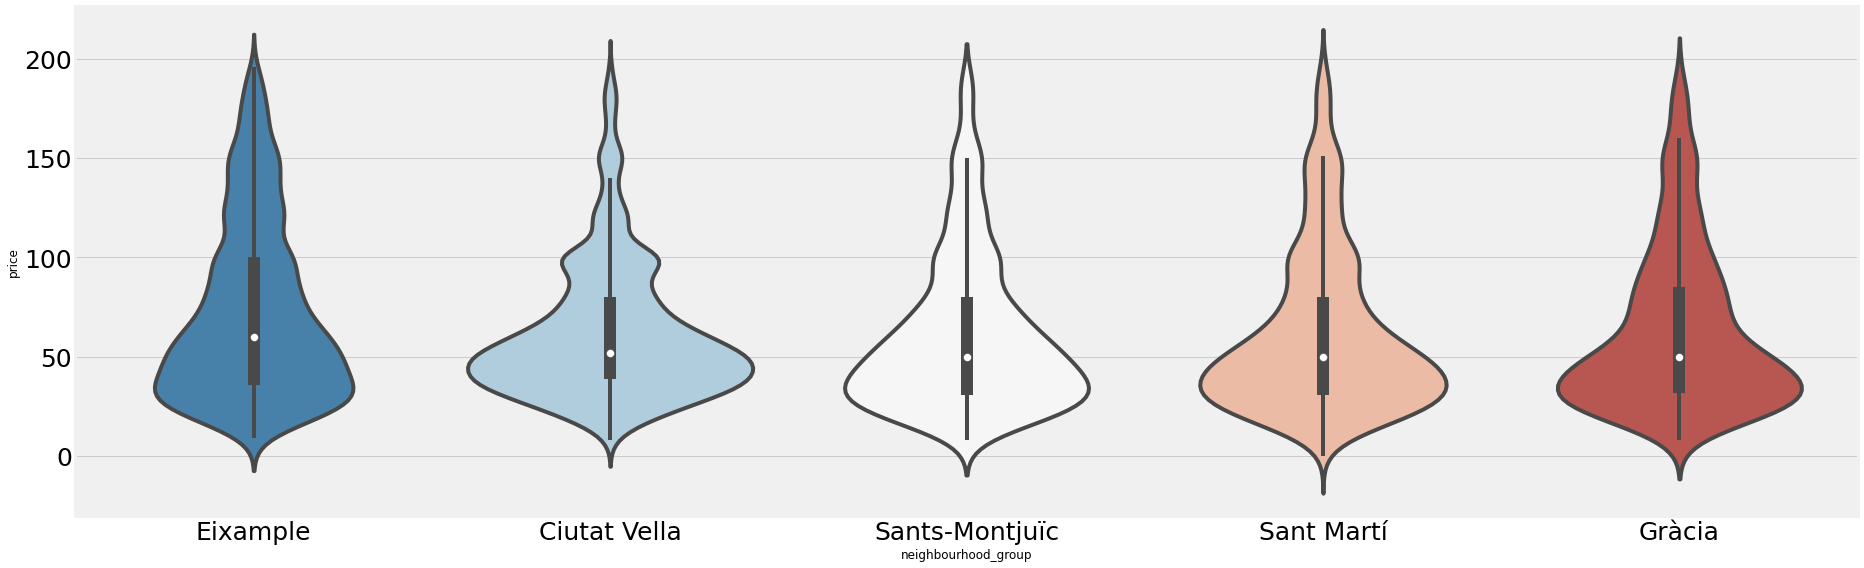

In [119]:
# Plotting Distribution of Price per neighbourhood_group
fig, ax = plt.subplots()
fig.set_size_inches(26, 8)
ax = sns.violinplot(x="neighbourhood_group", y="price", data=clean_sum_listings, 
                    order=clean_sum_listings.neighbourhood_group.value_counts().iloc[:5].index, palette = 'RdBu_r')

#ax.set_title(label='Distribution of Price per Neighbourhood group in Barcelona', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()

In [48]:
p =clean_sum_listings.groupby('neighbourhood_group')['price'].mean()
p.sort_values(ascending=False)

neighbourhood_group
Sarrià-Sant Gervasi    74.027907
Eixample               72.643136
Gràcia                 63.223476
Ciutat Vella           62.096144
Sant Martí             61.987021
Sants-Montjuïc         61.082110
Les Corts              58.070130
Horta-Guinardó         47.674912
Sant Andreu            40.702970
Nou Barris             37.743083
Name: price, dtype: float64

Text(0.5, 1.0, 'Boxplot of Price per Neighbourhood group in Barcelona')

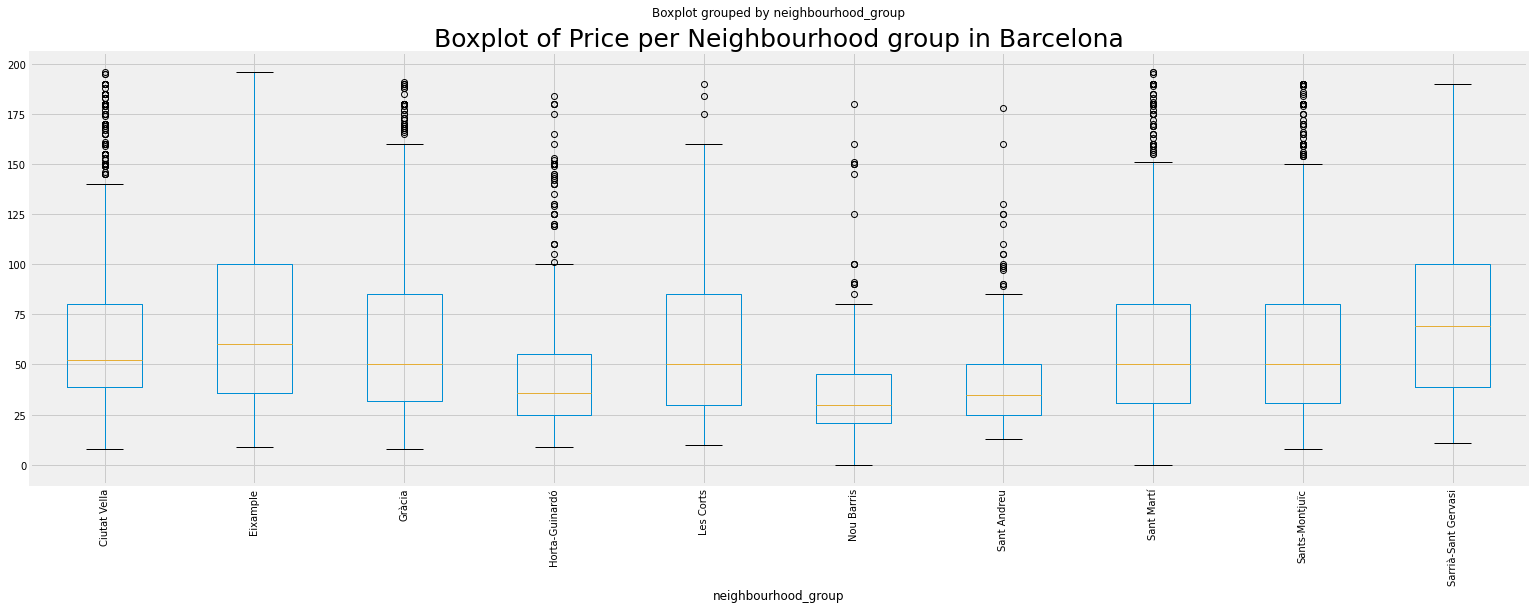

In [62]:
ax= clean_sum_listings.boxplot(column='price', by='neighbourhood_group', figsize=(26,8), rot=90)
ax.set_title(label='Boxplot of Price per Neighbourhood group in Barcelona', fontsize=25)

- Most of the neighborhoods reveal a significantly larger number of cheaper listings
- Eixample, contrary to the rest, seems to have a more distributed number of listings across all levels of prices
- Ciutat Vella holds the largest number of cheaper listings when compared to the remaining top neighborhoods in Barcelona

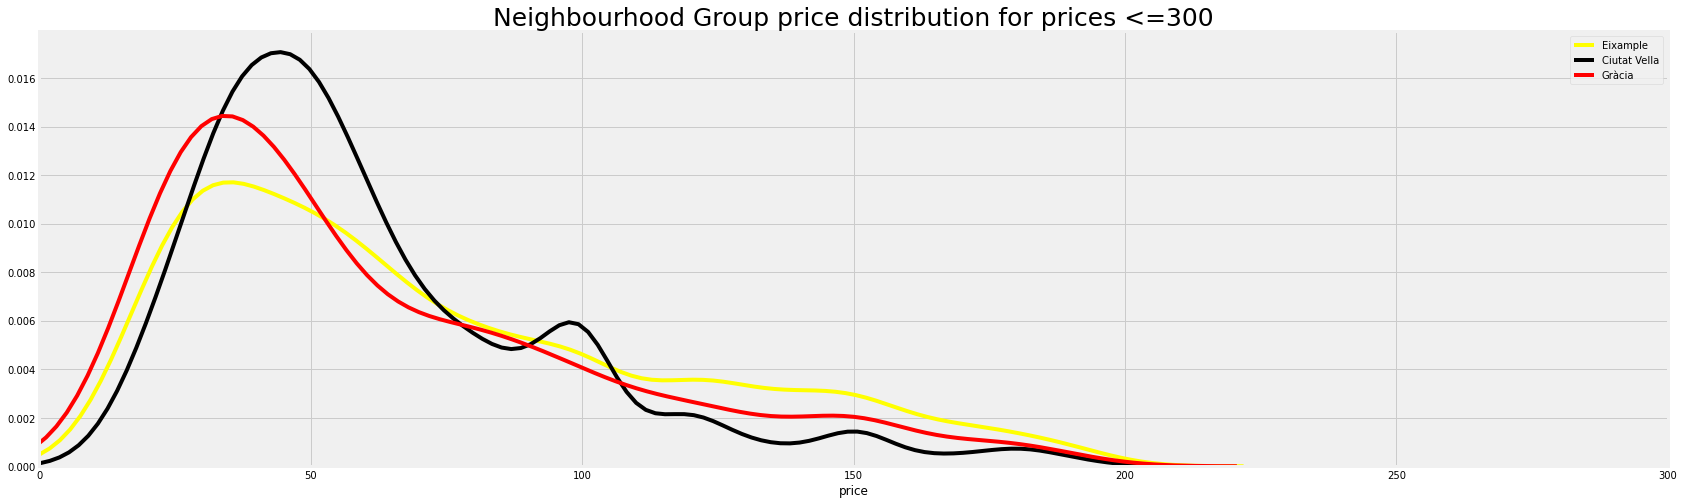

In [64]:
plt.figure(figsize = (26, 8))

sns.distplot(clean_sum_listings[clean_sum_listings.neighbourhood_group=='Eixample'].price,
             color='yellow',hist=False,label='Eixample')
sns.distplot(clean_sum_listings[clean_sum_listings.neighbourhood_group=='Ciutat Vella'].price,
             color='black',hist=False,label='Ciutat Vella')
sns.distplot(clean_sum_listings[clean_sum_listings.neighbourhood_group=='Sants-Montjuic'].price,
             color='green',hist=False,label='Sants-Montjuic')
sns.distplot(clean_sum_listings[clean_sum_listings.neighbourhood_group=='Sant Marti'].price,
             color='blue',hist=False,label='Sant Marti')
sns.distplot(clean_sum_listings[clean_sum_listings.neighbourhood_group=='Gràcia'].price,
             color='red',hist=False,label='Gràcia')

plt.title('Neighbourhood Group price distribution for prices <=300', fontsize=25)
plt.xlim(0,300)
plt.show()

- The graph above makes it easier to identify how Ciutat Vella has a larger number of cheaper listings

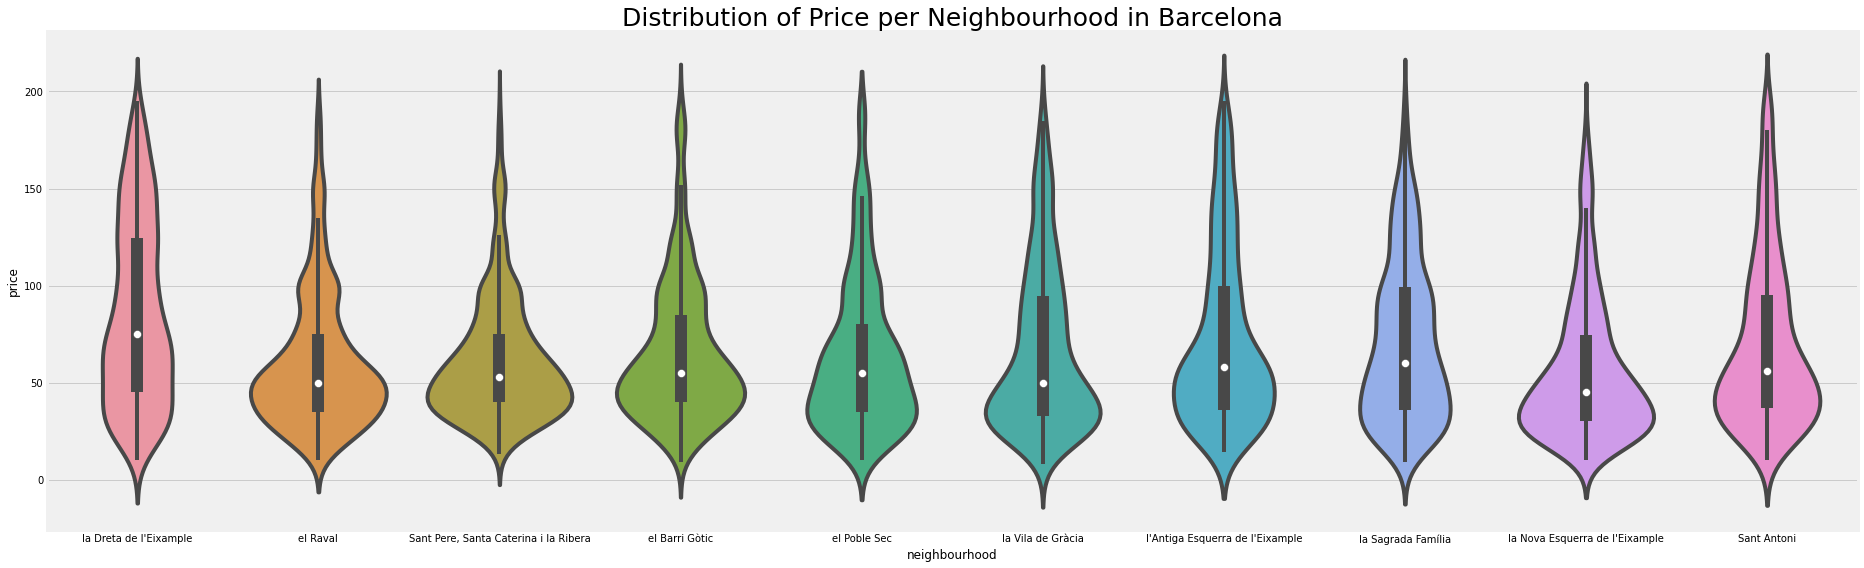

In [63]:
# Plotting Distribution of Price per neighbourhood

fig, ax = plt.subplots()
fig.set_size_inches(26, 8)
ax = sns.violinplot(x="neighbourhood", y="price", data=clean_sum_listings, order=clean_sum_listings.neighbourhood.value_counts().iloc[:10].index);
ax.set_title(label='Distribution of Price per Neighbourhood in Barcelona', fontsize=25);
plt.tight_layout()

- la Dreta de l'Eixample and la Sagrada Familia reveal a very equally distributed number of listings across all prices
- The remaining neighbourhoods have a larger number of cheaper listings, most likely driven by the number of private rooms 

Text(0.5, 1.0, 'Room Type vs Price')

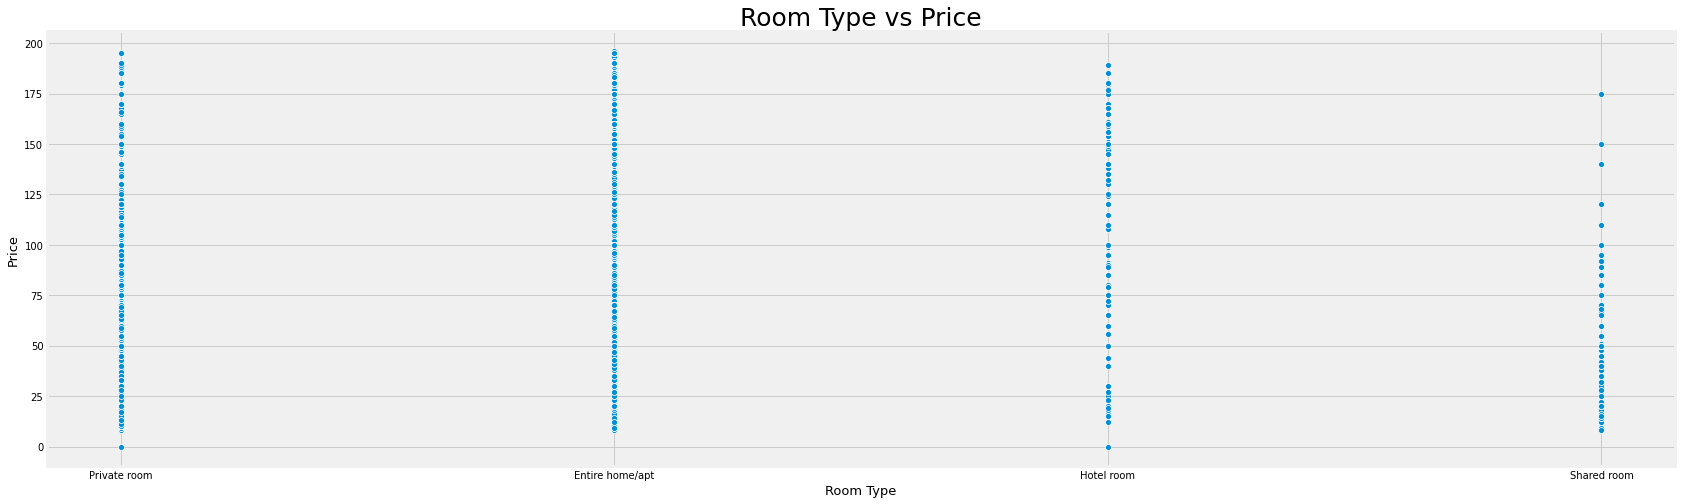

In [66]:
plt.figure(figsize=(26,8))
sns.scatterplot(x='room_type', y='price', data=clean_sum_listings)

plt.xlabel('Room Type', size=13)
plt.ylabel('Price', size=13)
plt.title('Room Type vs Price',size=25)

Text(0.5, 1.0, 'Most frequent choice for Minimum Nights')

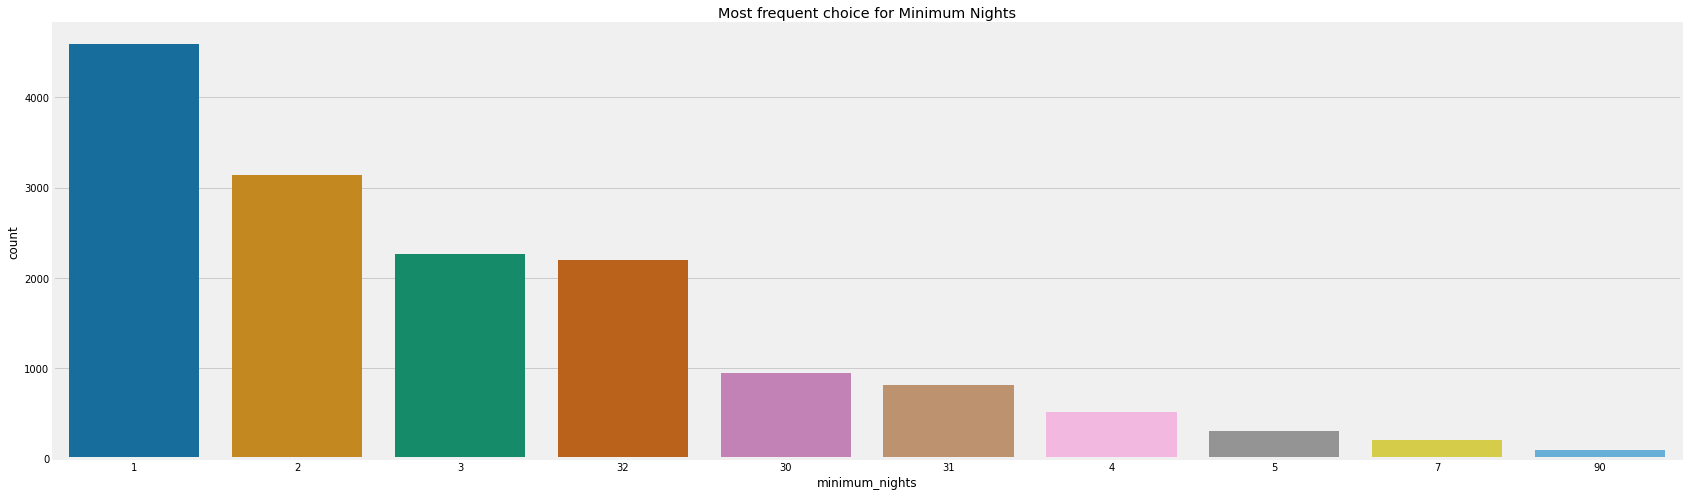

In [41]:
# Plotting Minimum Nights

fig, ax = plt.subplots()
fig.set_size_inches(26, 8)
ax = sns.countplot(x="minimum_nights", data=clean_sum_listings, palette="colorblind", 
                   order=clean_sum_listings.minimum_nights.value_counts().iloc[:10].index)

ax.set_title(label = 'Most frequent choice for Minimum Nights')

- Most listings in Barcelona have a period of up to 3 nights as minimum stay
- Most of the places only request a minimum stay of 1 night (4591 listings, 29.14% of Barcelona)

### 2.3 Geographical plotting 

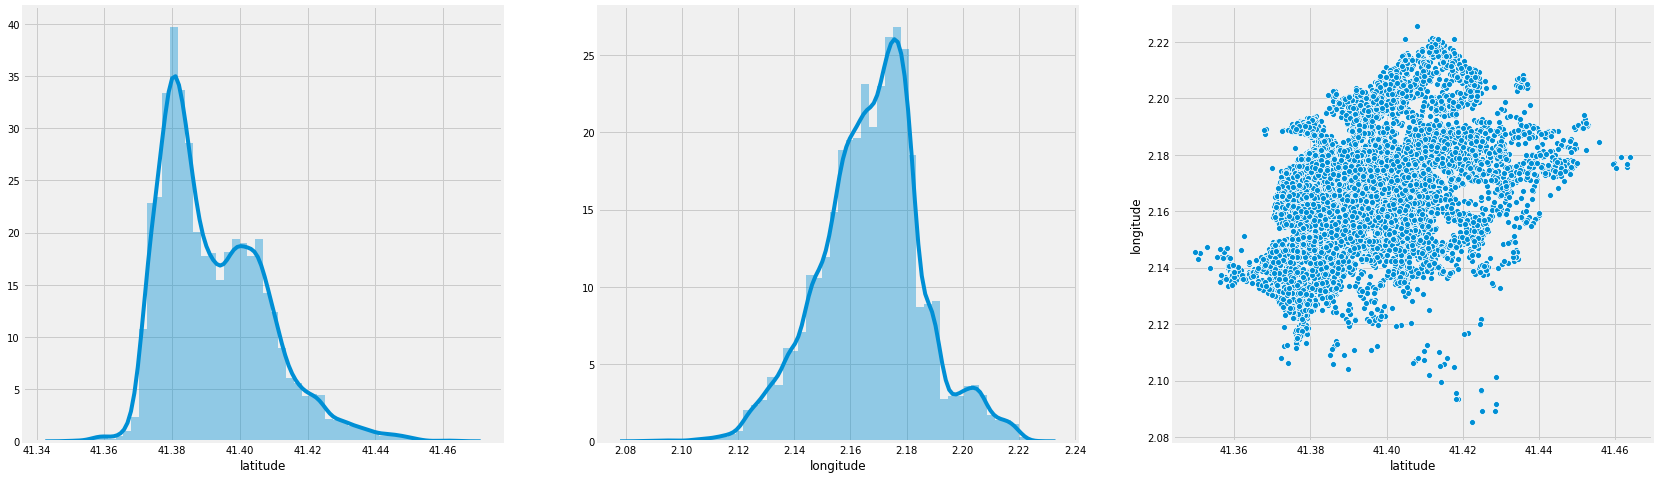

In [42]:
fig, axes = plt.subplots(1,3, figsize=(26,8))
sns.distplot(clean_sum_listings['latitude'], ax=axes[0])
sns.distplot(clean_sum_listings['longitude'], ax=axes[1])
sns.scatterplot(x= clean_sum_listings['latitude'], y=clean_sum_listings['longitude'])

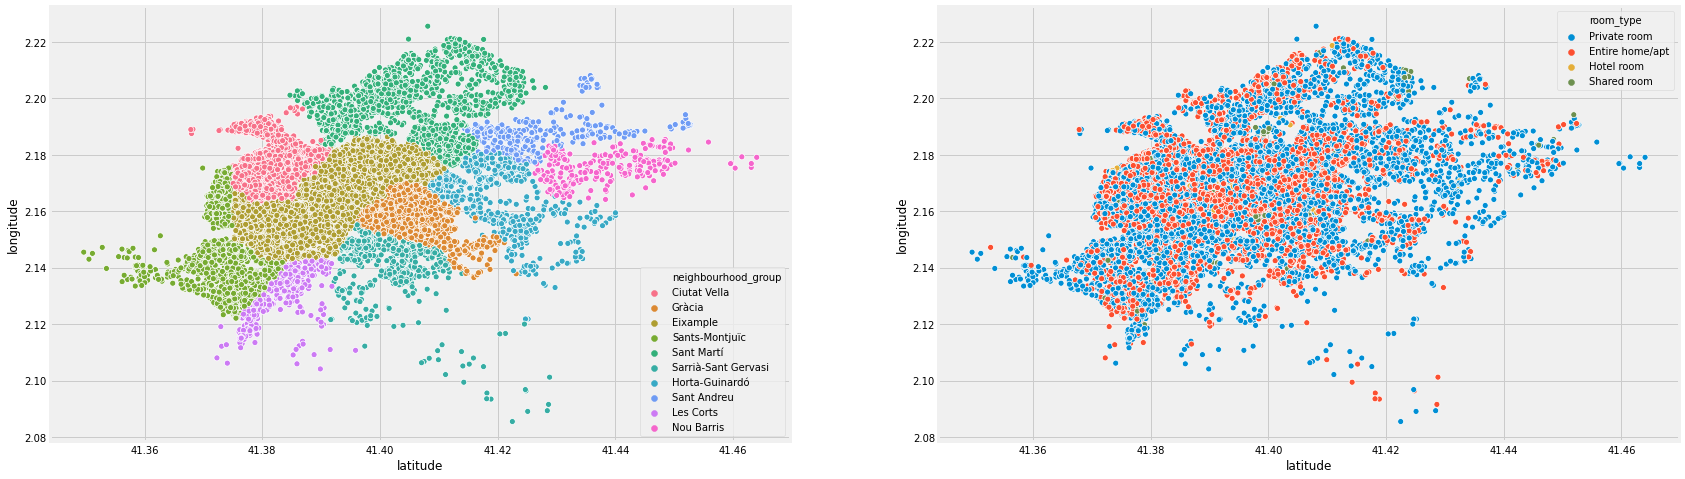

In [43]:
# plotting neighbourhood_group and room_type

fig, ax = plt.subplots()
fig.set_size_inches(26, 8)
plt.subplot(121)
sns.scatterplot(x='latitude', y='longitude',hue='neighbourhood_group', data=clean_sum_listings)
plt.subplot(122)
sns.scatterplot(x='latitude', y='longitude',hue='room_type', data=clean_sum_listings)

- As previously analysed, the distribution of room types across Barcelona reveals a slightly larger number of private rooms

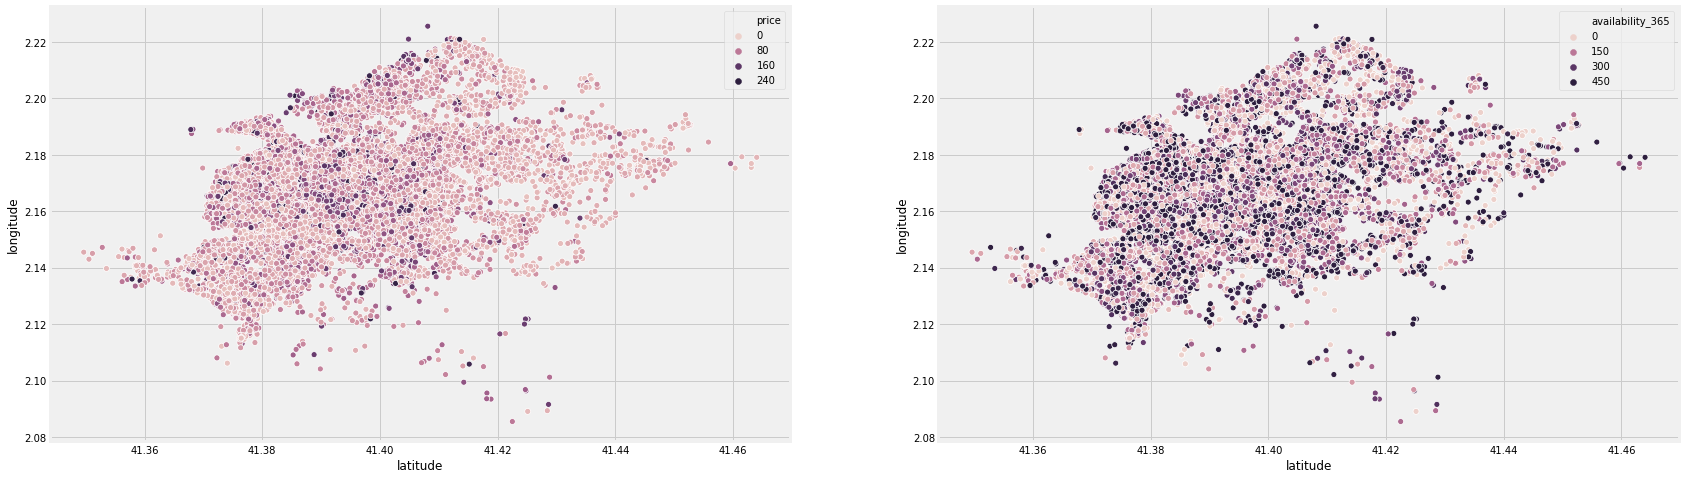

In [44]:
# plotting price and availability_365

fig, ax = plt.subplots()
fig.set_size_inches(26, 8)
plt.subplot(121)
sns.scatterplot(x='latitude', y='longitude',hue='price', data=clean_sum_listings)
plt.subplot(122)
sns.scatterplot(x='latitude', y='longitude',hue='availability_365', data=clean_sum_listings)

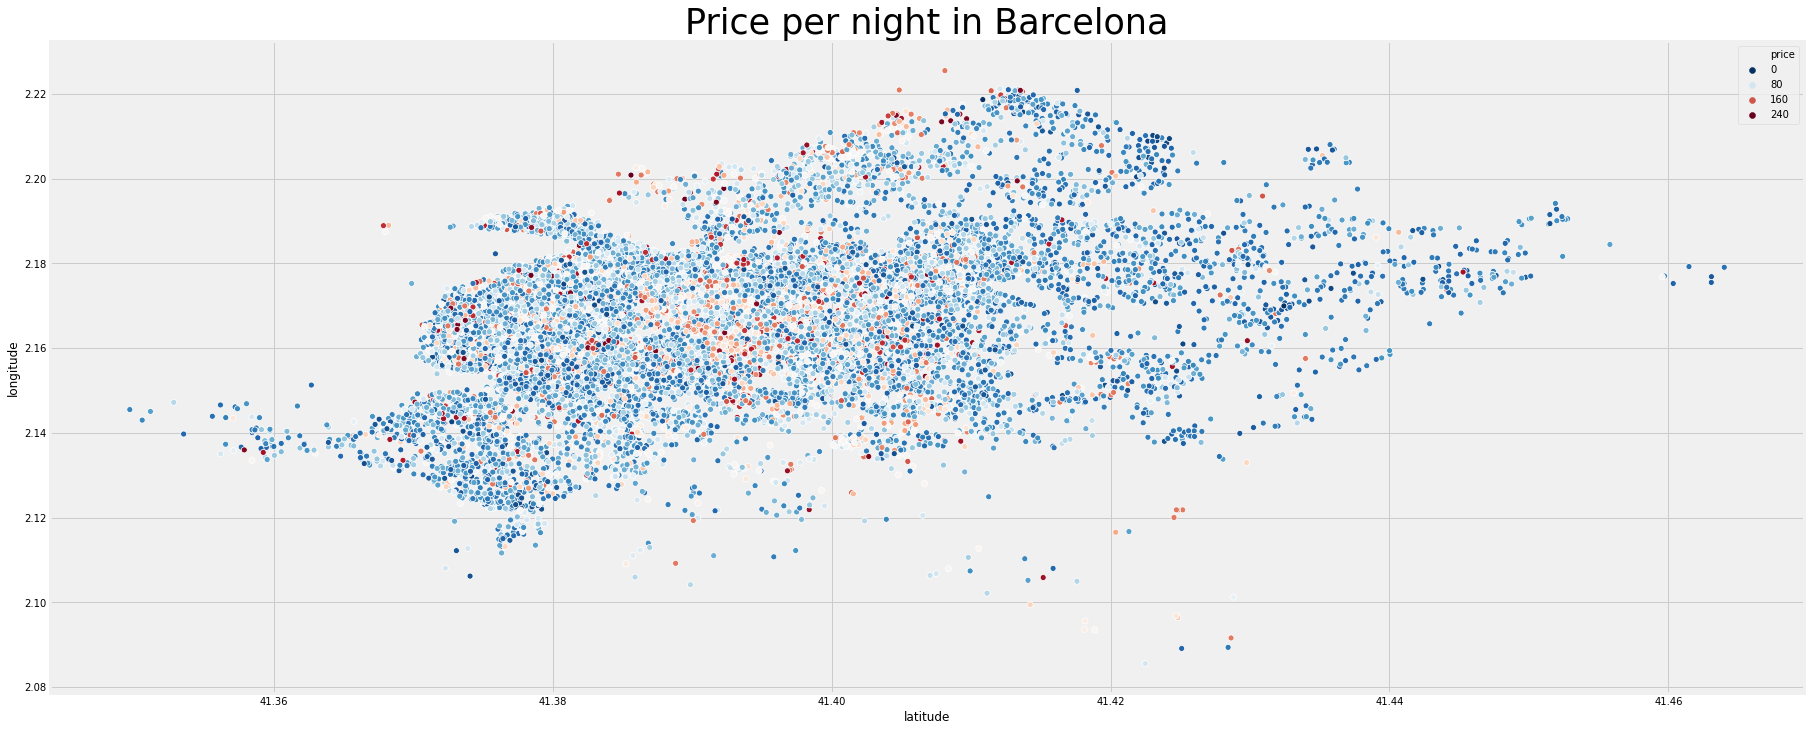

In [90]:
fig, ax = plt.subplots()

fig.set_size_inches(28, 12)
sns.scatterplot(x='latitude', y='longitude',hue='price', data=clean_sum_listings, palette = 'RdBu_r')
plt.title('Price per night in Barcelona',size=35)
plt.savefig('price.png')

- As expected, the most expensive listings are located in the neighbourhoods of Sarrià-Sant Gervasi, Eixample and Gràcia
- The listings with the least available days per years for rental are Sant Andreu, Sant Martí and Sants-Montjuïc

In [59]:
series = clean_sum_listings.groupby('neighbourhood_group').agg('mean')['price']
series.sort_values(ascending=False)

neighbourhood_group
Sarrià-Sant Gervasi    74.027907
Eixample               72.643136
Gràcia                 63.223476
Ciutat Vella           62.096144
Sant Martí             61.987021
Sants-Montjuïc         61.082110
Les Corts              58.070130
Horta-Guinardó         47.674912
Sant Andreu            40.702970
Nou Barris             37.743083
Name: price, dtype: float64

In [54]:
# Plotting a map of Barcelona and applying a Heatmap on top 

map_barna = folium.Map(location=[41.3851,2.1734], zoom_start=13)

# Adding a heatmap
HeatMap(data=clean_sum_listings[['latitude', 'longitude']], radius=10).add_to(map_barna)

# Displaying the map
map_barna

In [47]:
# Creating a map with number of listings plotted across Barcelona
listings = clean_sum_listings[['latitude', 'longitude']]
map_cluster = folium.Map(location=[41.3851,2.1734], zoom_start=12)

# Adding points to the map
mc = MarkerCluster()

for idx, row in listings.iterrows():
    mc.add_child(Marker([row['latitude'], row['longitude']]))

map_cluster.add_child(mc)

# Displaying the map
map_cluster

### 2.4 Word visualization

In [50]:
# Analysing the column name for most common terms used when publications

# Creating a list to append all the terms used
names = []

# Collecting all the name strings from the column and appending it to the new list
for name in clean_sum_listings['name']:
    names.append(name)
    
def split_words(name):
    spl=str(name).split()
    return spl    

# Creating new list to count the word frequency
frequent_words = []

# Collecting all the words in each name and appednding them to our new list 
for x in names:
    for word in split_words(x):
        word = word.lower()
        frequent_words.append(word)

In [51]:
from collections import Counter

# Counting 20 most frequent words used in titles of listings in Barcelona
top_20 = Counter(frequent_words).most_common()
top_20 = top_20[0:20]

# Creating a Dataframe with the word and respective frequency
most_freq_20 = pd.DataFrame(top_20)
most_freq_20.rename(columns={0:'Words', 1:'Count'}, inplace=True)
most_freq_20.head()

Words  Count
0       room   3883
1         in   3828
2  apartment   2501
3  barcelona   2069
4        the   1664

Text(0.5, 1.0, 'Top 20 used words for listing names in Barcelona')

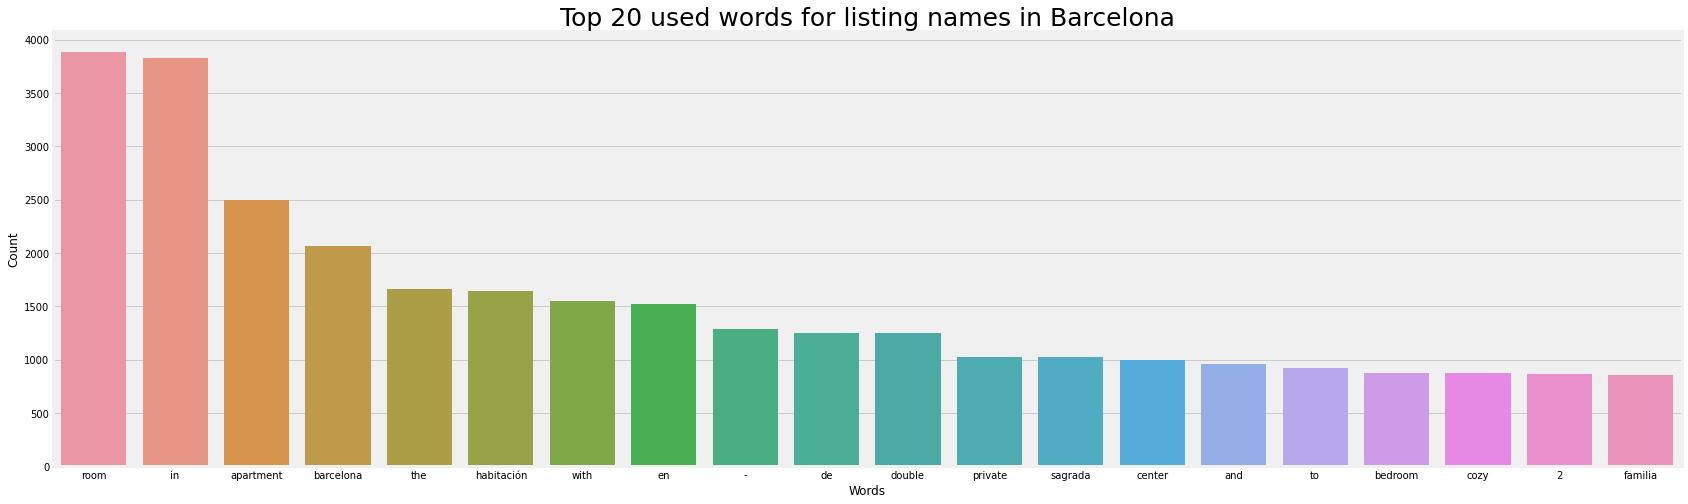

In [67]:
# Plotting 20 most common terms used in the name of the listings

plt.figure(figsize = (26, 8))
top_20=sns.barplot(x='Words', y='Count', data=most_freq_20)
top_20.set_title('Top 20 used words for listing names in Barcelona',fontsize=25)

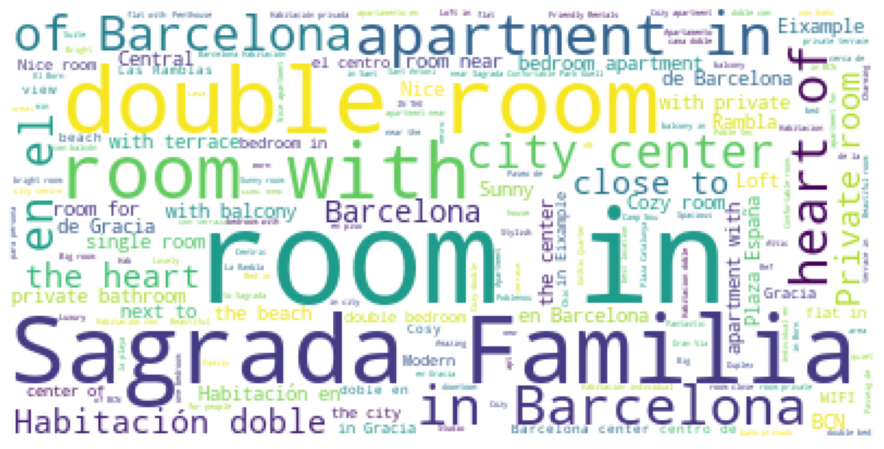

In [53]:
from wordcloud import WordCloud, ImageColorGenerator

plt.figure(figsize=(20,8))

words = ' '.join(str(word) for word in clean_sum_listings['name'])

# Generating a WordCloud with the the list of words 
wordcloud = WordCloud(max_words=200, background_color='white').generate(words)

# Displaying the WordCloud without the axis lines:
plt.imshow(wordcloud)
plt.axis("off")
2plt.show()